In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

C:\Users\msubr\Anaconda3\envs\bert\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("UCF-crime-frames-descriptions-partitions.csv")

In [3]:
data.head(2)

,Unnamed: 0,frame,directory,class,Description,partition
0,0,Abuse001_x264.mp4_frame_000000.jpg,Abuse_frames,Normal,a man is standing in the middle of a room,train
1,1,Abuse001_x264.mp4_frame_000010.jpg,Abuse_frames,Normal,a man is standing in the middle of a room,train


In [4]:
train = data.loc[data["partition"] == "train"]
val = data.loc[data["partition"] == "validation"]
test = data.loc[data["partition"] == "test"]

In [5]:
labels = {"Normal": 0,
          "Abuse": 1,
          "Arrest": 2,
          "Arson": 3,
          "Burglary": 4,
          "Explosion": 5,
          "Fighting": 6,
          "RoadAccidents": 7,
          "Shooting": 8,
          "Vandalism": 9
         }

In [6]:
def evaluate(data):
    with torch.no_grad():
        d_pred = torch.zeros([len(data), 10])
        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size]
            batch = batch.to(device)
            pred = model(batch)
            d_pred[i:i+batch_size] = pred 
    return d_pred

In [15]:
def get_data(df):
    X = np.zeros((len(df), 768))
    path = "d:/data/UCF-crime/Anomaly-Videos-qformer-features"
    c = 0
    for _, f in df.iterrows():
        directory = f["directory"][:-7] 
        X[c] = np.load(f"{path}/{directory}/{f['frame']}.npy")
        c += 1
    X = torch.tensor(X, dtype=torch.float32)
    y = list(df["class"])
    y = [labels[lbl] for lbl in y]
    y = torch.tensor(y, dtype=torch.float32)
    return X, y

In [12]:
def get_acc(pred, target, return_sum=False):
    s = (torch.argmax(pred, dim=1).round() == target).sum()
    if (return_sum == True):
        return s
    return s/len(pred)

In [13]:
def get_acc_per_lbl(pred, target, return_sum=False):
    for i in range(len(labels)):
        p = (target == i).sum()
        t = (torch.argmax(pred, dim=1) == i).sum()
        s = ((torch.argmax(pred, dim=1) == i) & (target == i)).sum()
        presc = s/t
        recall = s/p
        print(f"{i}, presc {s/t:.2f}, recall {s/p:.2f}, f1 {2*presc*recall/(presc+recall):.2f}\t total {p} {list(labels.keys())[i]}")
    
    return 

In [16]:
V, y_val = get_data(val)
V.shape, y_val.shape
X, y = get_data(train)
X.shape, y.shape

(torch.Size([124145, 768]), torch.Size([124145]))

In [17]:
np.save( "train_qformer.npy", X.numpy())
np.save( "val_qformer.npy", V.numpy())

In [10]:
X = np.load("train.npy")
V = np.load("val.npy")
X = torch.tensor(X, dtype=torch.float32)
V = torch.tensor(V, dtype=torch.float32)
y = list(train["class"])
y = np.array([labels[lbl] for lbl in y])
y = torch.tensor(y, dtype=torch.float32)
y_val = list(val["class"])
y_val = np.array([labels[lbl] for lbl in y_val])
y_val = torch.tensor(y_val, dtype=torch.float32)

In [22]:
labels_counts = torch.tensor([(y==i).sum() for i in range(len(labels))])
weights = 1 - labels_counts / len(X)    

In [85]:
#weights = torch.tensor([0.1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [35]:
model = nn.Sequential(
    nn.Linear(768, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

In [36]:
sum(param.numel() for param in model.parameters())

462346

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Sequential(
  (0): Linear(in_features=768, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=10, bias=True)
)

In [38]:
weights = weights.to(device)
loss_fn = nn.CrossEntropyLoss(weights)  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [39]:
n_epochs = 30
batch_size = 64
for epoch in range(n_epochs):
    acc = 0
    perm = torch.randperm(len(X))
    for i in range(0, len(X), batch_size):
        Xbatch = X[perm[i:i+batch_size]]
        Xbatch = Xbatch.to(device)
        y_pred = model(Xbatch)
        ybatch = y[perm[i:i+batch_size]]
        ybatch = ybatch.type(torch.LongTensor)
        ybatch = ybatch.to(device)
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc += get_acc(y_pred, ybatch, return_sum=True)
    val_pred = evaluate(V)
        
    print(f'Finished epoch {epoch}, latest loss {loss}, acc {acc/len(X)} val_acc {get_acc(val_pred, y_val)}')

Finished epoch 0, latest loss 1.366774320602417, acc 0.6733900308609009 val_acc 0.6595965027809143
Finished epoch 1, latest loss 1.2839109897613525, acc 0.720125675201416 val_acc 0.66994309425354
Finished epoch 2, latest loss 1.224818229675293, acc 0.7474405169487 val_acc 0.6486808061599731
Finished epoch 3, latest loss 0.7282005548477173, acc 0.7572919130325317 val_acc 0.6122090220451355
Finished epoch 4, latest loss 0.9290388226509094, acc 0.7683354616165161 val_acc 0.6274702548980713
Finished epoch 5, latest loss 0.7768005132675171, acc 0.7767288684844971 val_acc 0.6101914048194885
Finished epoch 6, latest loss 0.744841456413269, acc 0.7866849303245544 val_acc 0.6079151630401611
Finished epoch 7, latest loss 0.8883184194564819, acc 0.798292338848114 val_acc 0.6370925903320312
Finished epoch 8, latest loss 0.8954456448554993, acc 0.8074510097503662 val_acc 0.6239006519317627
Finished epoch 9, latest loss 0.48572492599487305, acc 0.813983678817749 val_acc 0.6164510846138
Finished epoc

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from torch.nn.functional import one_hot

In [41]:
CLASS_LABELS = ["normal", 
                "Abuse",
                "Arrest",
                "Arson",
                "Burglary",
                "Explosion",
                "Fighting",
                "RoadAccidents",
                "Shooting",
                "Vandalism"]

def multiclass_roc_auc_score(y_true, y_pred, average="macro"):    
    fig, c_ax = plt.subplots(1,1, figsize = (8,5))
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve((y_true == idx).type(torch.int32), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    y_true = one_hot(y_true.type(torch.LongTensor))
    plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
    plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
    plt.legend(fontsize = 11.5)
    plt.show()
    return roc_auc_score(y_true, y_pred, average=average)


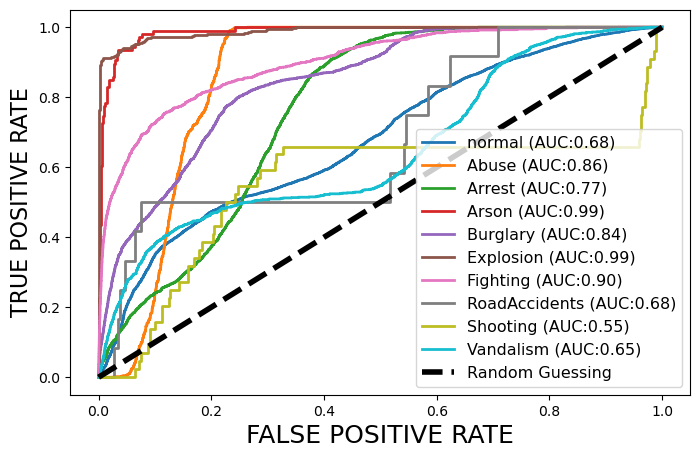

ROC AUC score: 0.790597017784123


In [42]:
print('ROC AUC score:', multiclass_roc_auc_score(y_val , val_pred, average = "macro"))

In [43]:
get_acc_per_lbl(val_pred, y_val)

0, presc 0.73, recall 0.89, f1 0.80	 total 12895 Normal
1, presc 0.37, recall 0.41, f1 0.39	 total 646 Abuse
2, presc 0.55, recall 0.11, f1 0.18	 total 1321 Arrest
3, presc 0.26, recall 0.80, f1 0.40	 total 106 Arson
4, presc 0.24, recall 0.14, f1 0.18	 total 1767 Burglary
5, presc 0.98, recall 0.81, f1 0.89	 total 388 Explosion
6, presc 0.44, recall 0.26, f1 0.32	 total 1132 Fighting
7, presc nan, recall 0.00, f1 nan	 total 12 RoadAccidents
8, presc 0.02, recall 0.02, f1 0.02	 total 44 Shooting
9, presc 0.28, recall 0.10, f1 0.15	 total 1019 Vandalism


In [44]:
get_acc(val_pred, y_val)

tensor(0.6667)

In [45]:
X_pred = evaluate(X)

In [46]:
get_acc_per_lbl(X_pred, y)

0, presc 0.94, recall 0.88, f1 0.91	 total 84684 Normal
1, presc 0.60, recall 0.67, f1 0.63	 total 2593 Abuse
2, presc 0.86, recall 0.97, f1 0.91	 total 10454 Arrest
3, presc 0.79, recall 0.89, f1 0.84	 total 4984 Arson
4, presc 0.80, recall 0.96, f1 0.87	 total 8211 Burglary
5, presc 0.70, recall 0.82, f1 0.76	 total 2138 Explosion
6, presc 0.66, recall 0.85, f1 0.75	 total 6178 Fighting
7, presc 0.40, recall 0.02, f1 0.03	 total 689 RoadAccidents
8, presc 0.47, recall 0.43, f1 0.45	 total 1568 Shooting
9, presc 0.66, recall 0.80, f1 0.72	 total 2646 Vandalism


In [47]:
get_acc(X_pred, y)

tensor(0.8719)

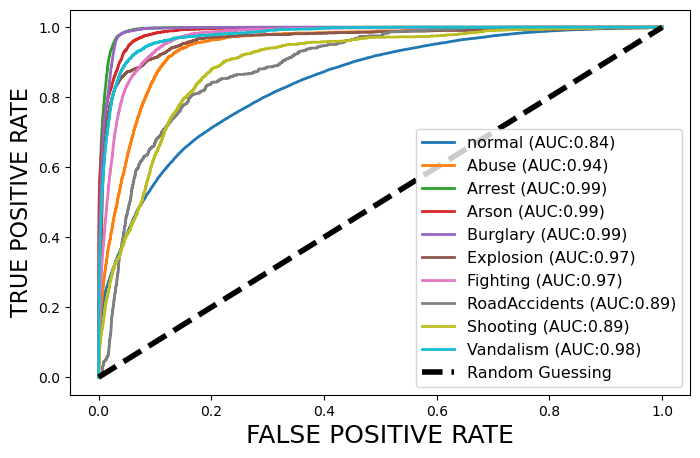

ROC AUC score: 0.9456002969369235


In [48]:

print('ROC AUC score:', multiclass_roc_auc_score(y , X_pred, average = "macro"))


In [49]:
torch.save(model.state_dict(), "model_image_qformer_features.pt")